In [1]:
import copy
import pandas
import warnings
import subprocess
from matplotlib import pyplot as plt
import os
import sys

sys.path.insert(0, "../../src")
from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

#pandas.set_option('display.max_rows', 1000)

sys.path.insert(0, "../src")

csv_file = "summary.csv"


In [2]:
# Make a pivot table for operation throughput for query and graph it
pd = pandas.read_csv(csv_file)

def mapper(x):
    snippet = x["Task Name"][len("insert_only_"):]
    tokens = snippet.split("_")
    return (tokens[0], int(tokens[1]), int(tokens[2]), int(tokens[3]))
pd.insert(0, "Distribution", pd.apply(lambda x: mapper(x)[0], axis=1))
pd.insert(1, "EncryptedFields", pd.apply(lambda x: mapper(x)[1], axis=1))
pd.insert(2, "ContentionFactor", pd.apply(lambda x: mapper(x)[2], axis=1))
pd.insert(3, "Threads", pd.apply(lambda x: mapper(x)[3], axis=1))

def Raise(x):
    raise RuntimeError(x)
pd.apply(lambda x: Raise("Constraint Violation" + x.to_string()) if x["ErrorRate"] != 0 else True, axis=1)
pd.apply(lambda x: Raise("Constraint Violation" + x.to_string()) if (x["WorkersMin"] != x["WorkersMax"] or x["WorkersMin"] != x["Threads"]) else True, axis=1)
pd.apply(lambda x: Raise("Constraint Violation" + x.to_string()) if (x["OperationThroughput"] != x["DocumentThroughput"]) else True, axis=1)



pd = pd.drop(columns = ["Patch ID", "Execution", "Test", "ErrorsTotal", "Topology", "WorkersMax", "WorkersMin", "ErrorRate", "DocumentThroughput", "DocumentsTotal"])
pd["DurationTotal"] /= 1_000_000
pd["OverheadTotal"] /= 1_000_000


pd["LatencyMin"] /= 1_000_000
pd["LatencyMax"] /= 1_000_000
pd["AverageLatency"] /= 1_000_000
pd["Latency50thPercentile"] /= 1_000_000
pd["Latency80thPercentile"] /= 1_000_000
pd["Latency90thPercentile"] /= 1_000_000
pd["Latency95thPercentile"] /= 1_000_000
pd["Latency99thPercentile"] /= 1_000_000


pd.sort_values(
    inplace=True,
    by=["Distribution", "EncryptedFields", "ContentionFactor","Threads"]
)
pd.query("Distribution == 'blimit' & Threads == 4")

,Distribution,EncryptedFields,ContentionFactor,Threads,Task Name,OperationsTotal,SizeTotal,DurationTotal,OverheadTotal,AverageLatency,AverageSize,OperationThroughput,SizeThroughput,LatencyMin,LatencyMax,Latency50thPercentile,Latency80thPercentile,Latency90thPercentile,Latency95thPercentile,Latency99thPercentile
6,blimit,0,1,4,insert_only_blimit_0_1_4,1000000,169000000,536924.0,62379.247236,2.083699,169.0,1862.460981,314755.905864,0.848704,248.909027,2.153919,2.647883,2.792220,2.927731,3.336069
10,blimit,0,4,4,insert_only_blimit_0_4_4,1000000,169000000,642083.0,73842.083373,2.495230,169.0,1557.431049,263205.847219,0.960089,232.854979,2.489596,2.958080,3.219774,3.513499,4.317106
14,blimit,0,8,4,insert_only_blimit_0_8_4,1000000,169000000,586412.0,62506.735825,2.281098,169.0,1705.285704,288193.283903,0.871795,224.293917,2.325091,2.794026,3.002440,3.219070,4.033597
2,blimit,0,16,4,insert_only_blimit_0_16_4,1000000,169000000,627643.0,69390.738081,2.440139,169.0,1593.262412,269261.347613,0.878135,250.664369,2.425215,2.892861,3.102257,3.306810,4.085958
31,blimit,1,1,4,insert_only_blimit_1_1_4,1000000,169000000,609414.0,88219.697036,2.348055,169.0,1640.920622,277315.585136,1.003586,209.511825,2.358776,2.780394,2.982222,3.183402,4.094071
35,blimit,1,4,4,insert_only_blimit_1_4_4,1000000,169000000,609215.0,94132.078376,2.342880,169.0,1641.456629,277406.170235,1.021689,196.192158,2.364547,2.728653,2.897197,3.055317,3.614839
39,blimit,1,8,4,insert_only_blimit_1_8_4,1000000,169000000,610111.0,87991.880817,2.351641,169.0,1639.046010,276998.775633,0.986829,211.743241,2.347109,2.787126,3.020140,3.280959,4.247647
27,blimit,1,16,4,insert_only_blimit_1_16_4,1000000,169000000,580194.0,96678.118775,2.224368,169.0,1723.561429,291281.881578,0.982044,209.984394,2.297584,2.675648,2.831513,2.977374,3.438944
47,blimit,5,1,4,insert_only_blimit_5_1_4,1000000,169000000,24747089.0,74621.780175,98.688185,169.0,40.408793,6829.086039,14.114222,22675.291986,33.491437,71.437225,119.750413,195.295198,1206.247662
51,blimit,5,4,4,insert_only_blimit_5_4_4,1000000,169000000,16855006.0,66146.297139,67.167217,169.0,59.329555,10026.694740,14.515078,13499.669935,38.390866,76.040892,110.391988,151.277740,376.393695


<AxesSubplot: xlabel='Task Name', ylabel='Duration (Milliseconds)'>

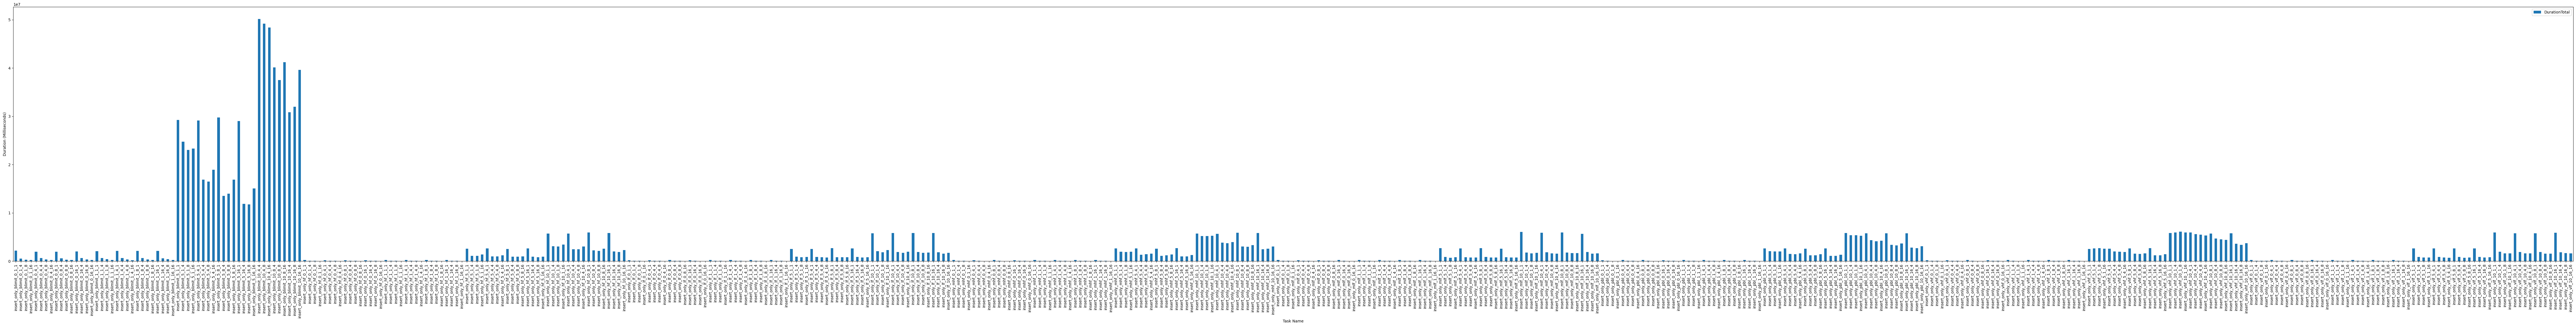

In [3]:
# Let's visualize how long these took to run!

pd.plot.bar(x="Task Name", y="DurationTotal", ylabel="Duration (Milliseconds)", figsize=(120,12))

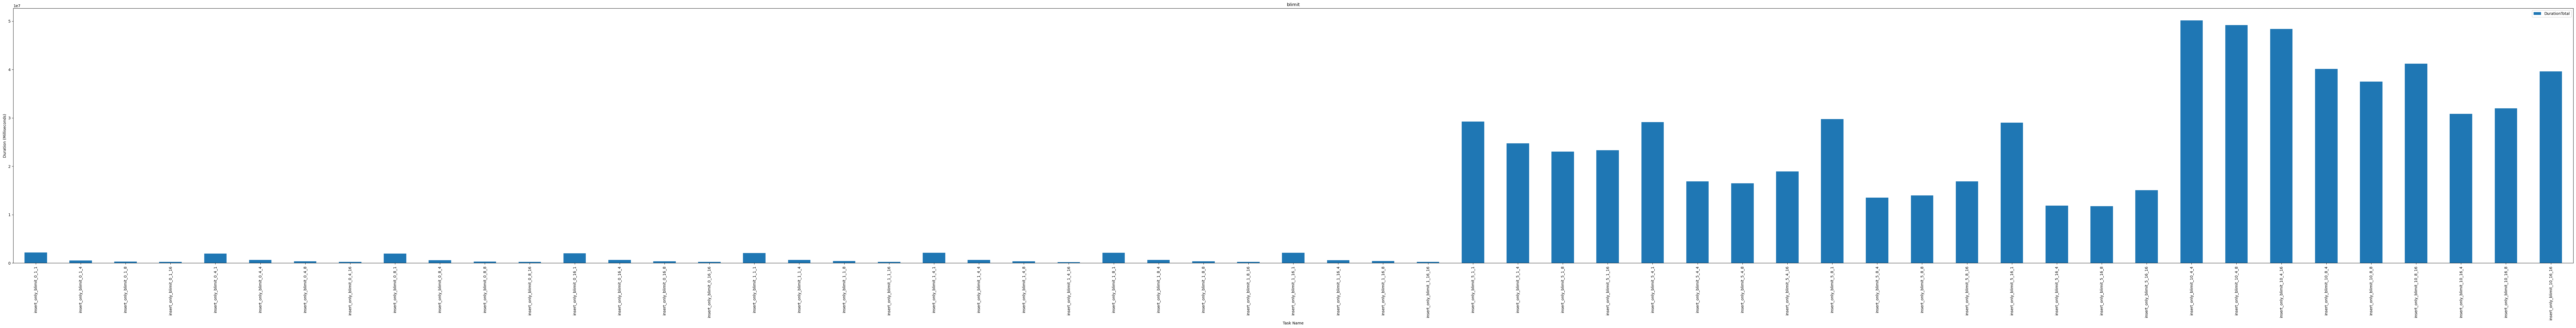

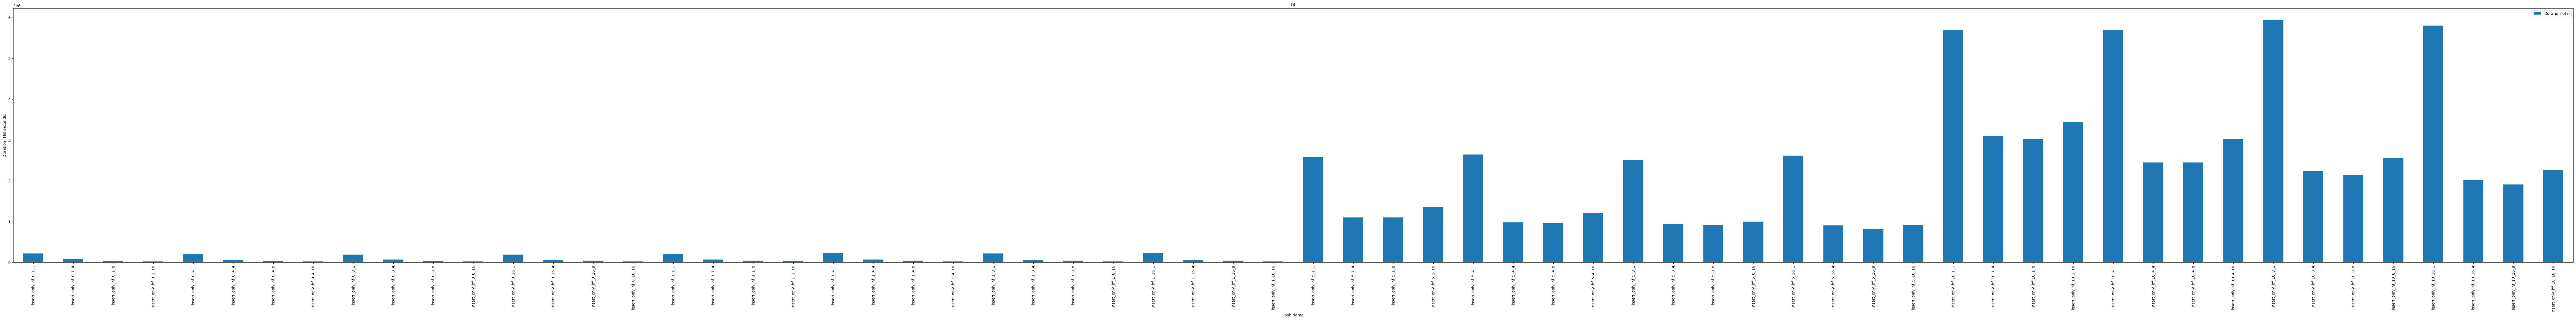

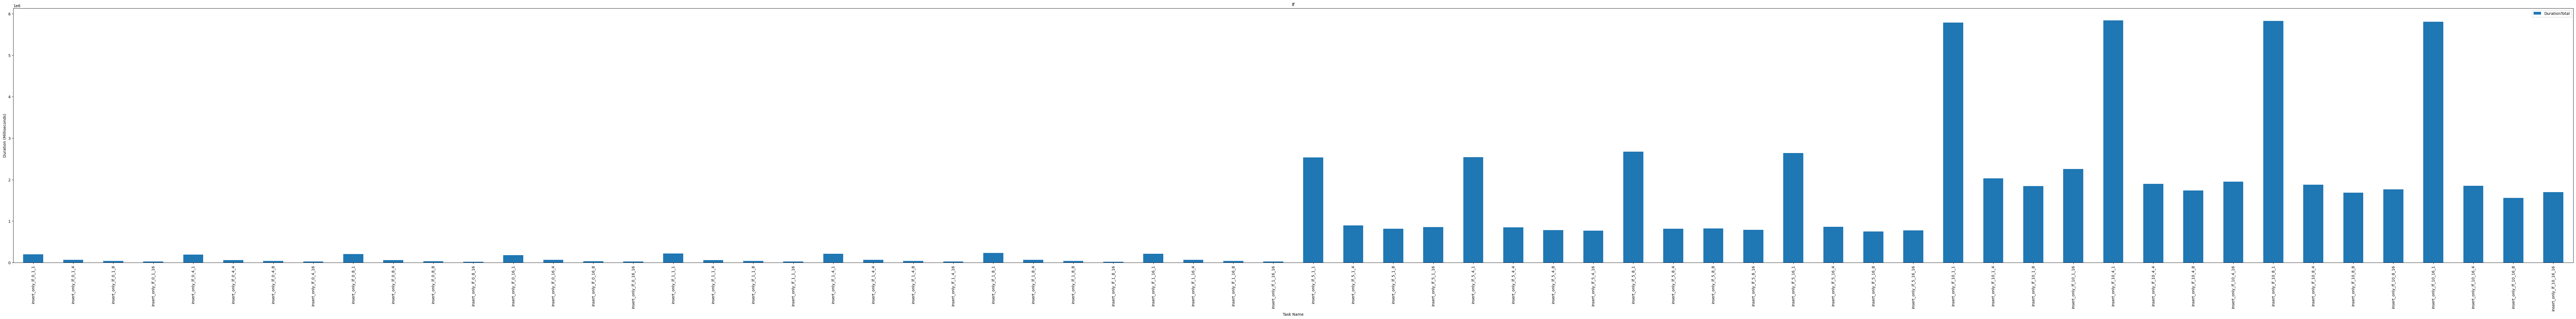

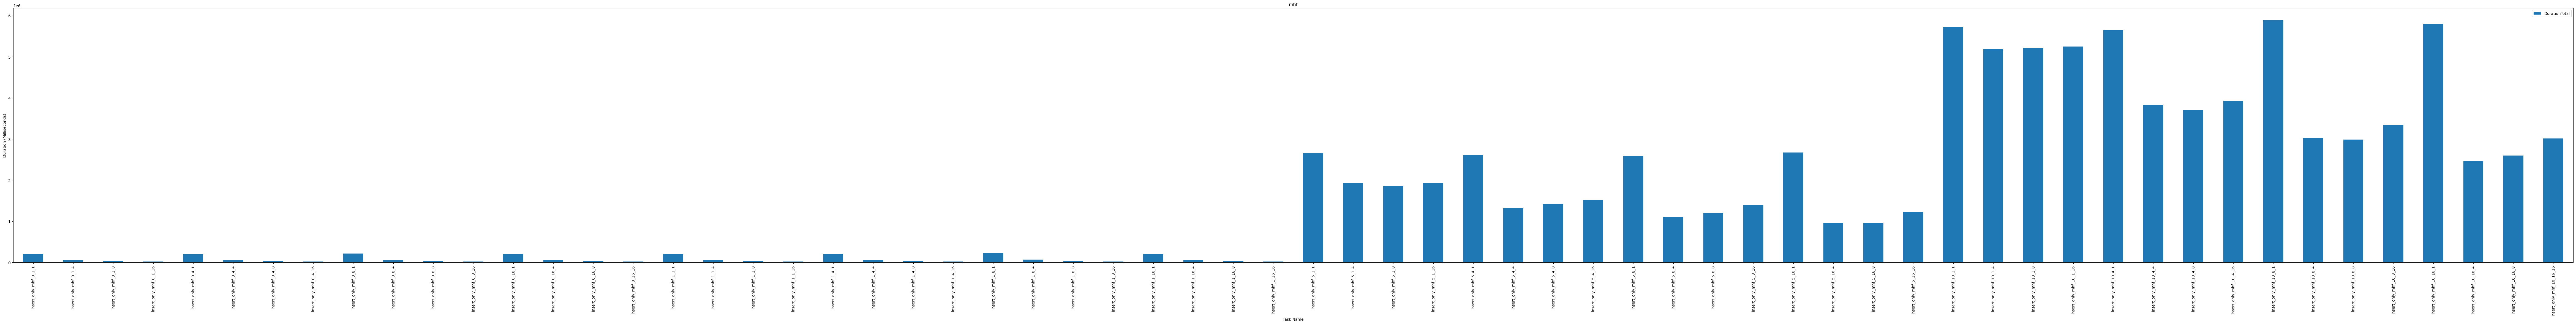

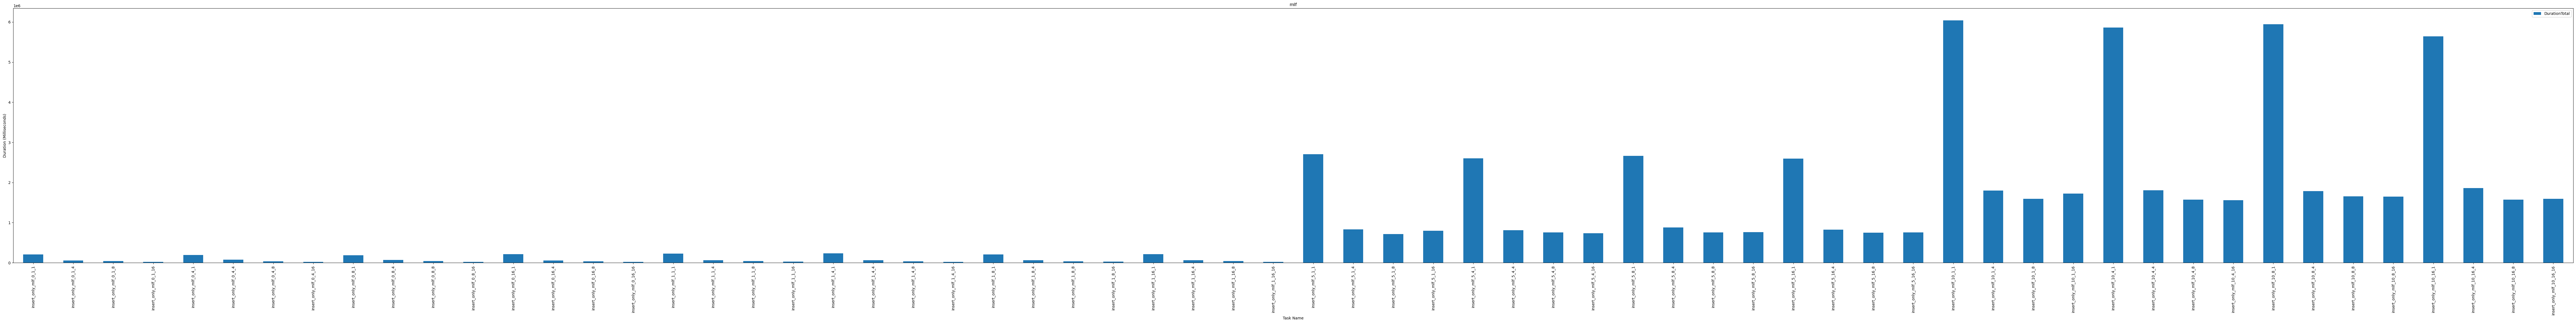

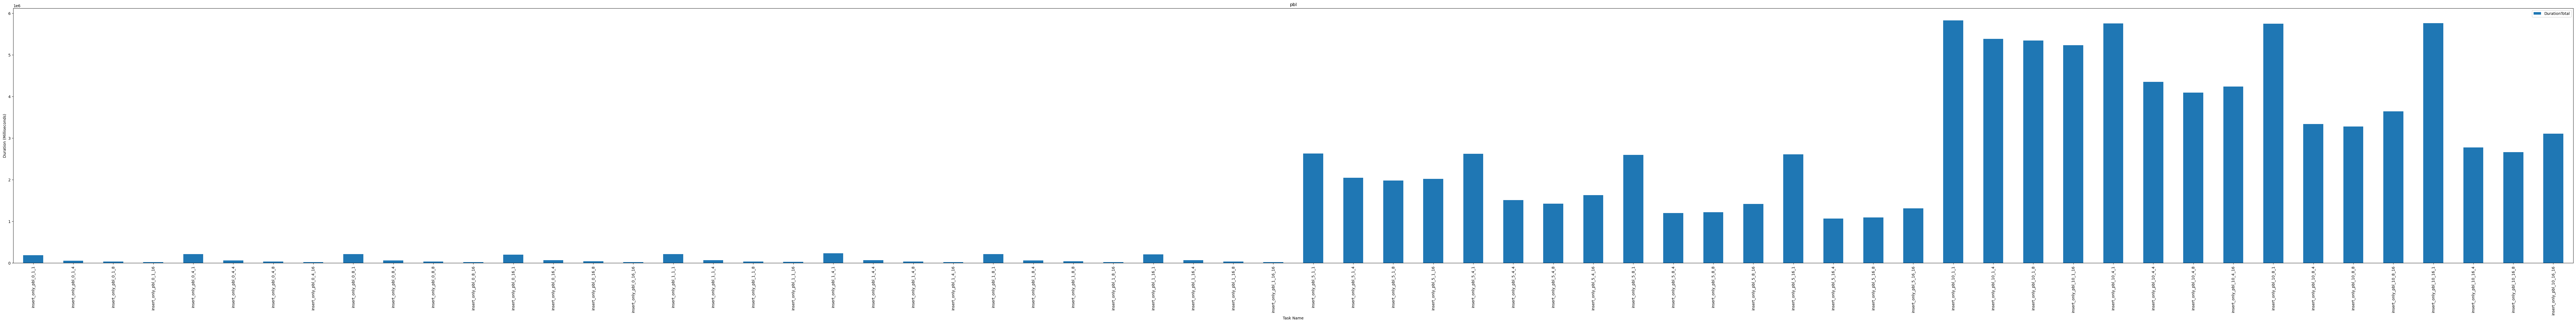

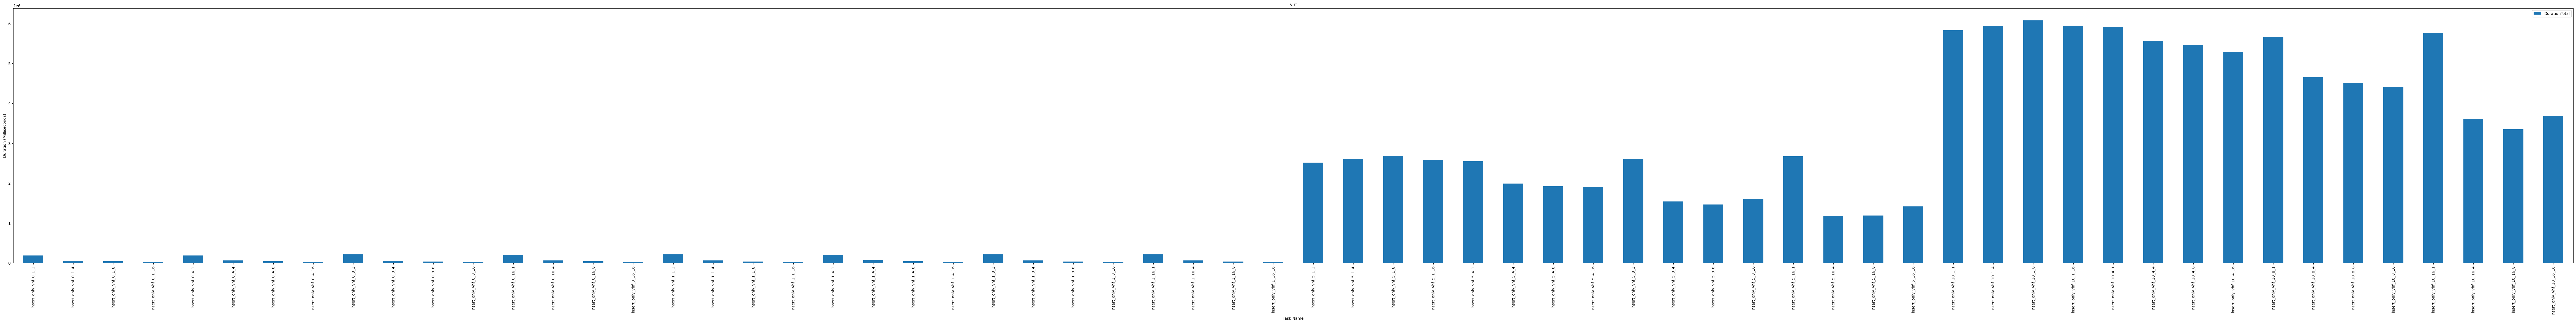

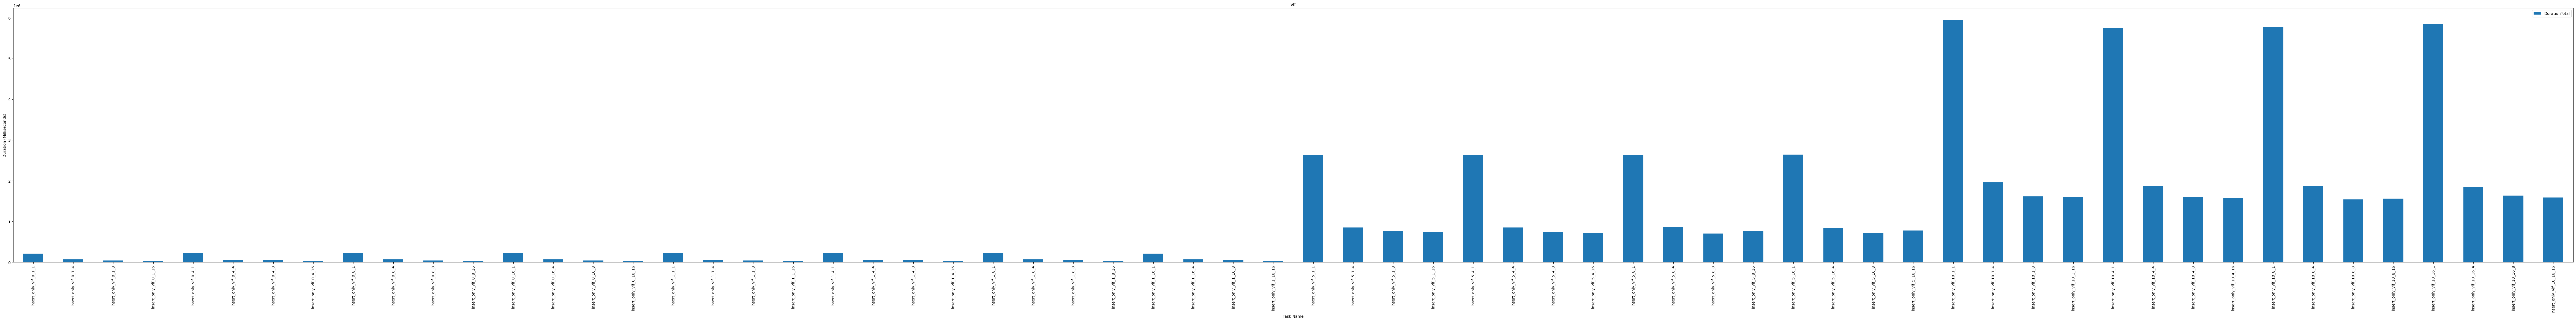

In [4]:
#So, maybe blimit's a little rough. Let's plot every data distribution separately, with their own scales

for name, group in pd.groupby(pd.Distribution):
    group.plot.bar(x="Task Name", y="DurationTotal", ylabel="Duration (Milliseconds)", figsize=(120,12)).set_title(name)

In [5]:
"""
Why is every fourth bar higher than usual? Because it represents a single threaded workload, and those just pretty consistently took longer.
Why does blimit not see that signal as clearly, especially toward the right of the graph? Unfortunatly, a number of the EncryptedFields=10 runs failed in that distribution because they took too long.
"""

'\nWhy is every fourth bar higher than usual? Because it represents a single threaded workload, and those just pretty consistently took longer.\nWhy does blimit not see that signal as clearly, especially toward the right of the graph? Unfortunatly, a number of the EncryptedFields=10 runs failed in that distribution because they took too long.\n'

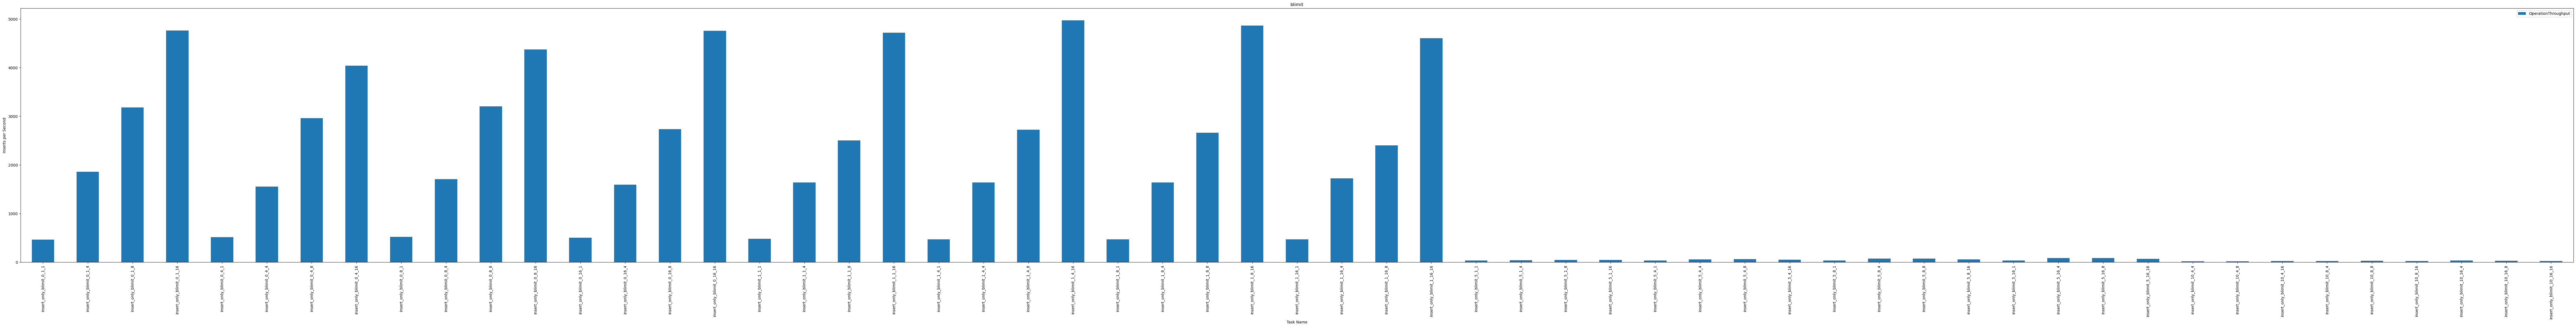

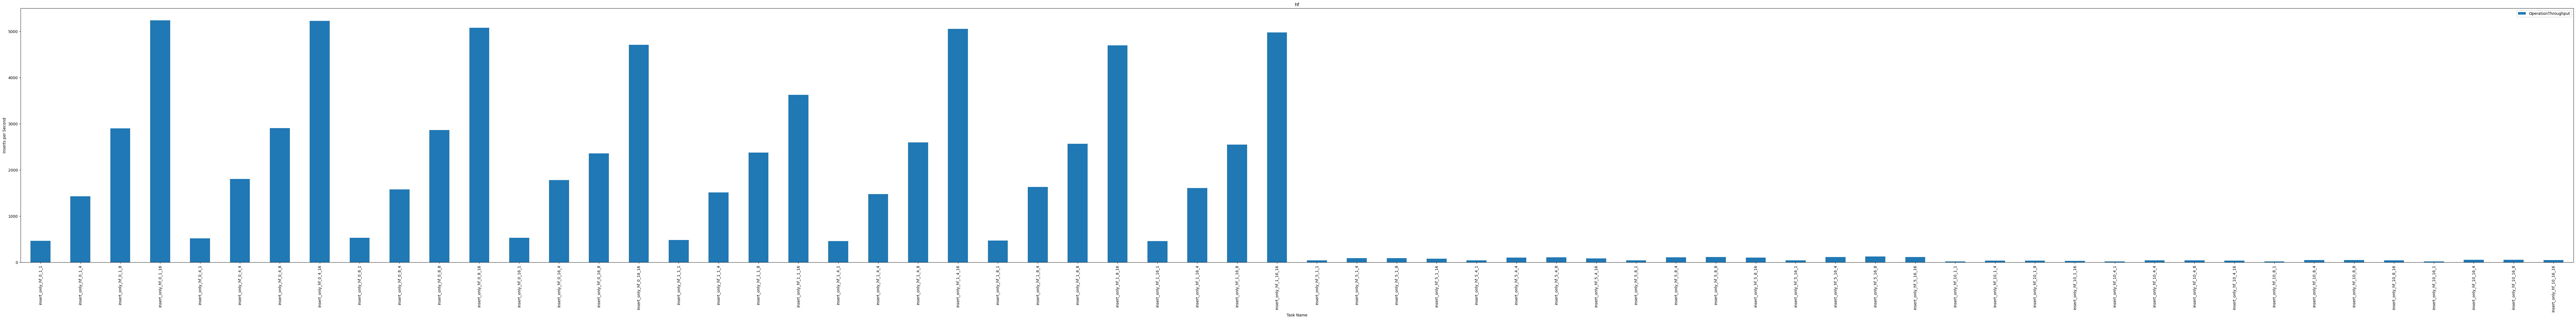

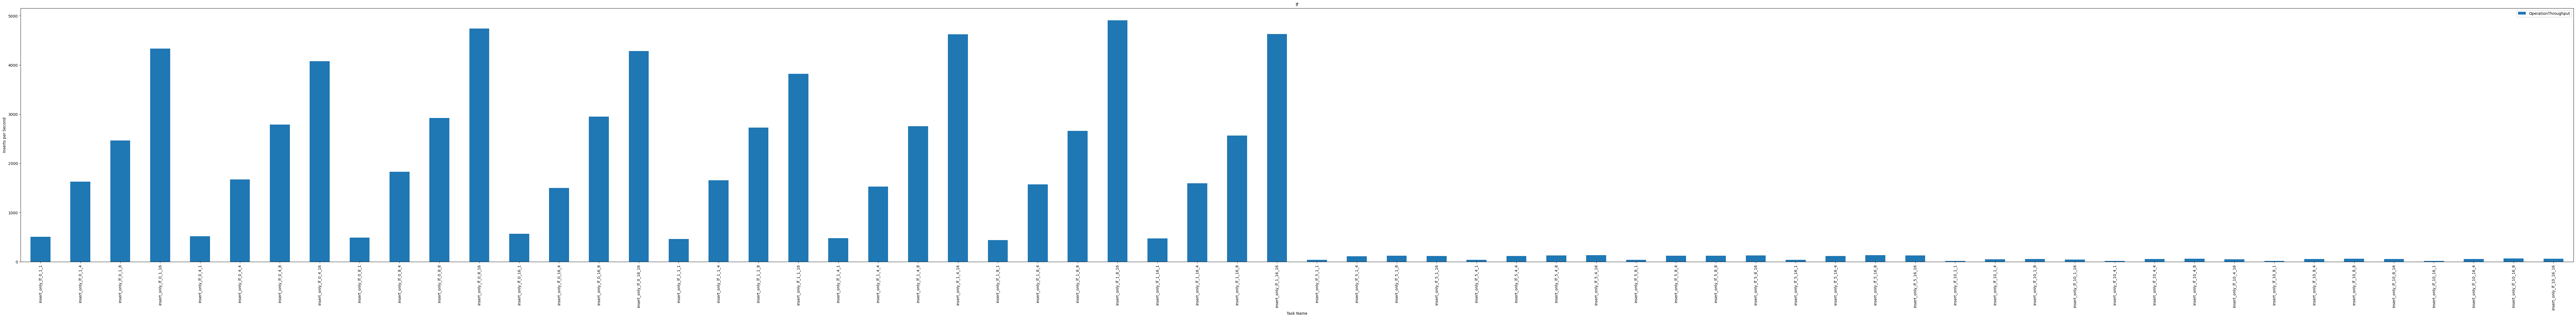

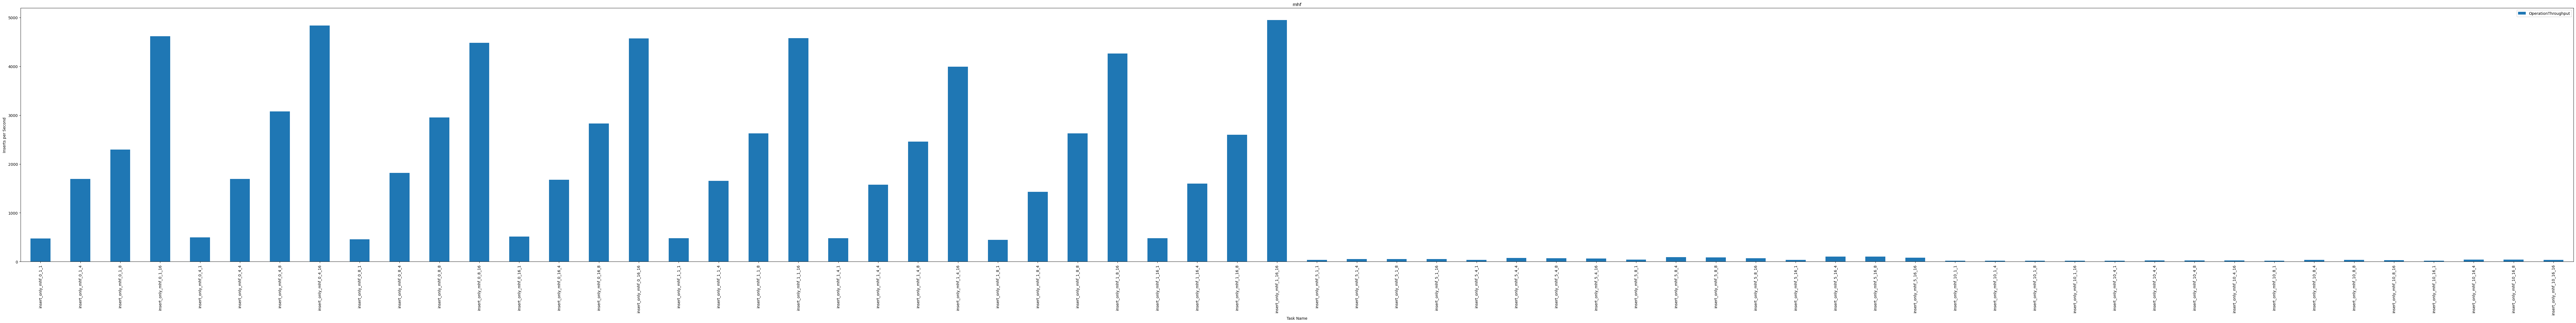

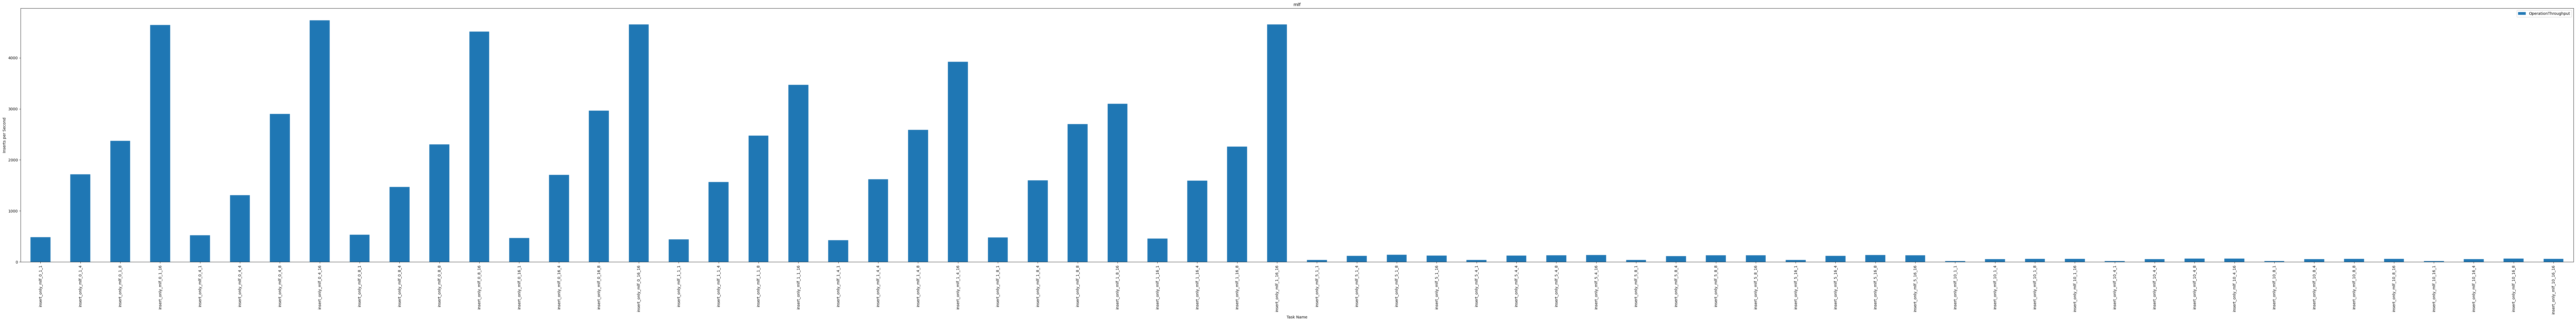

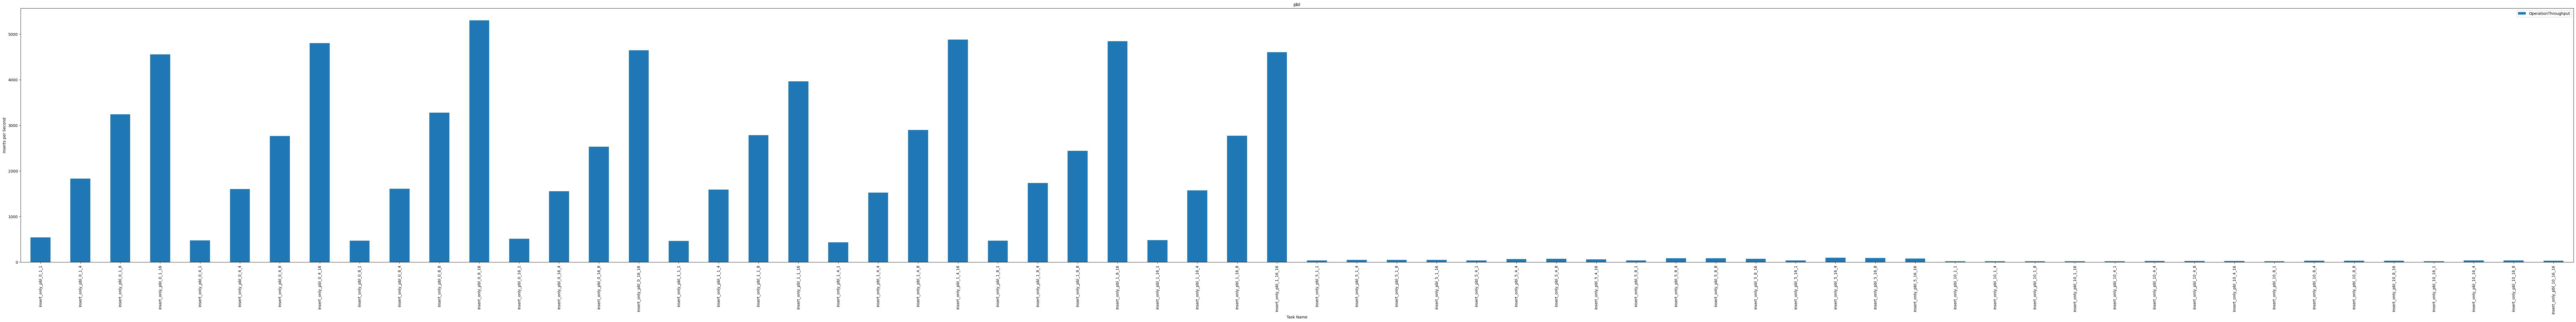

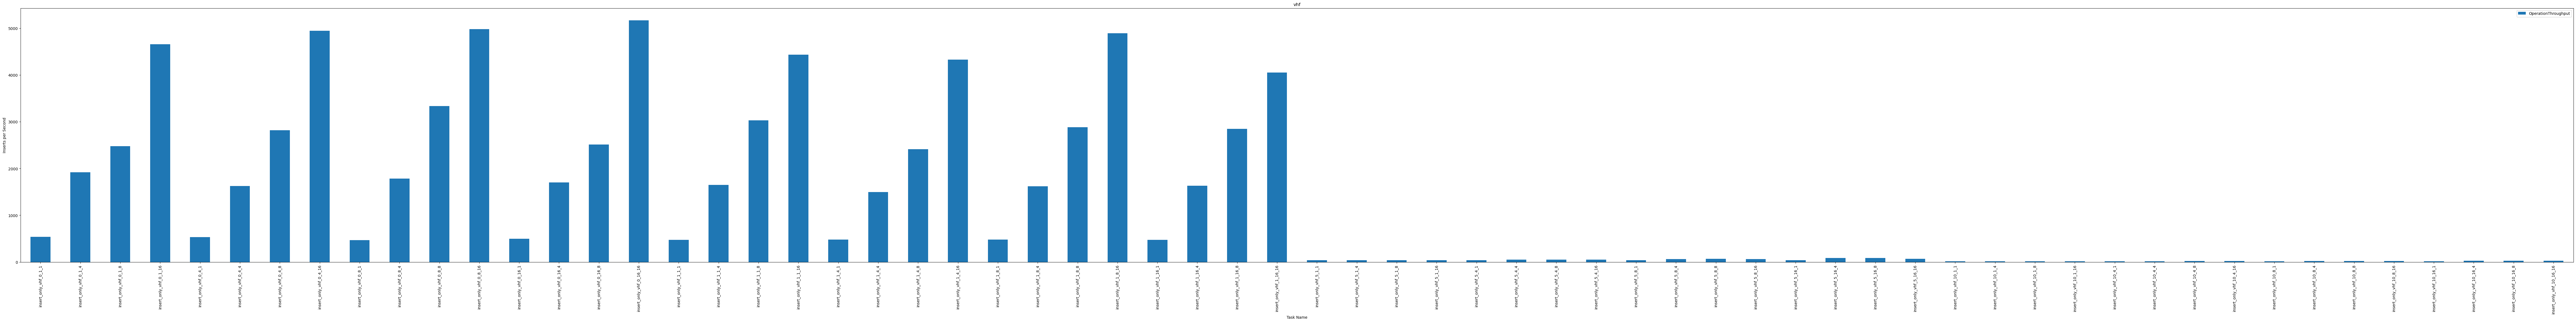

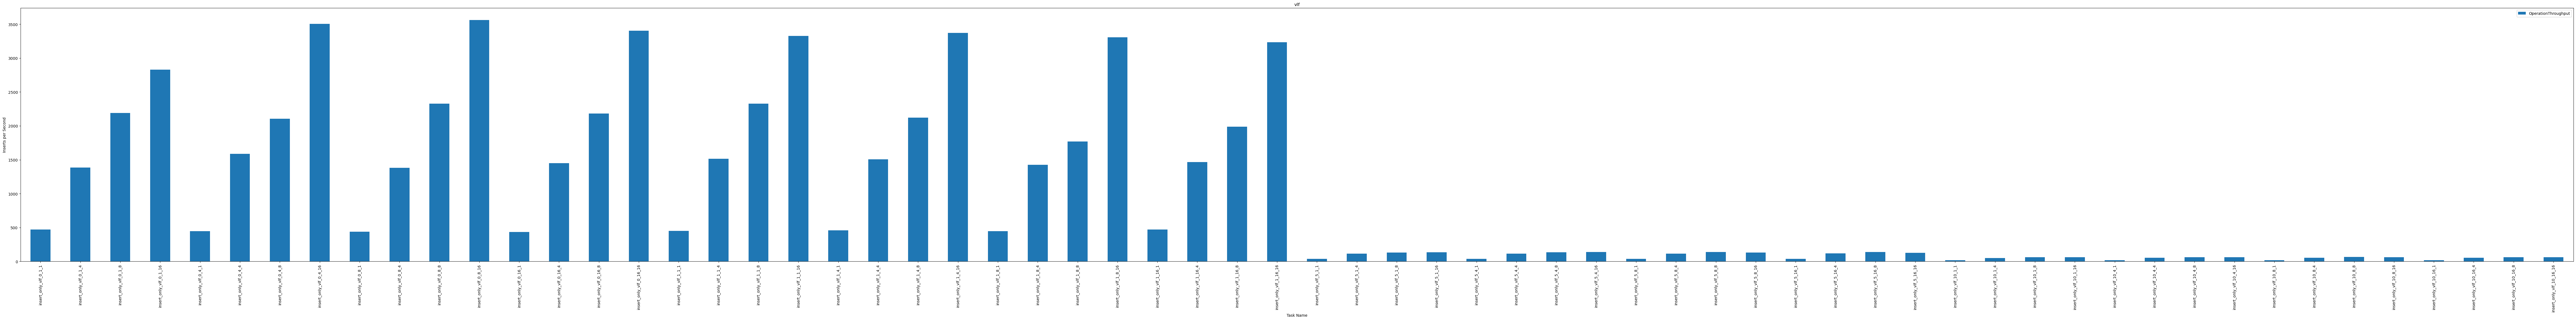

In [6]:
# Ok, that was fun. Let's look at throughput
for name, group in pd.groupby(pd.Distribution):
    group.plot.bar(x="Task Name", y="OperationThroughput", ylabel="Inserts per Second", figsize=(120,12)).set_title(name)

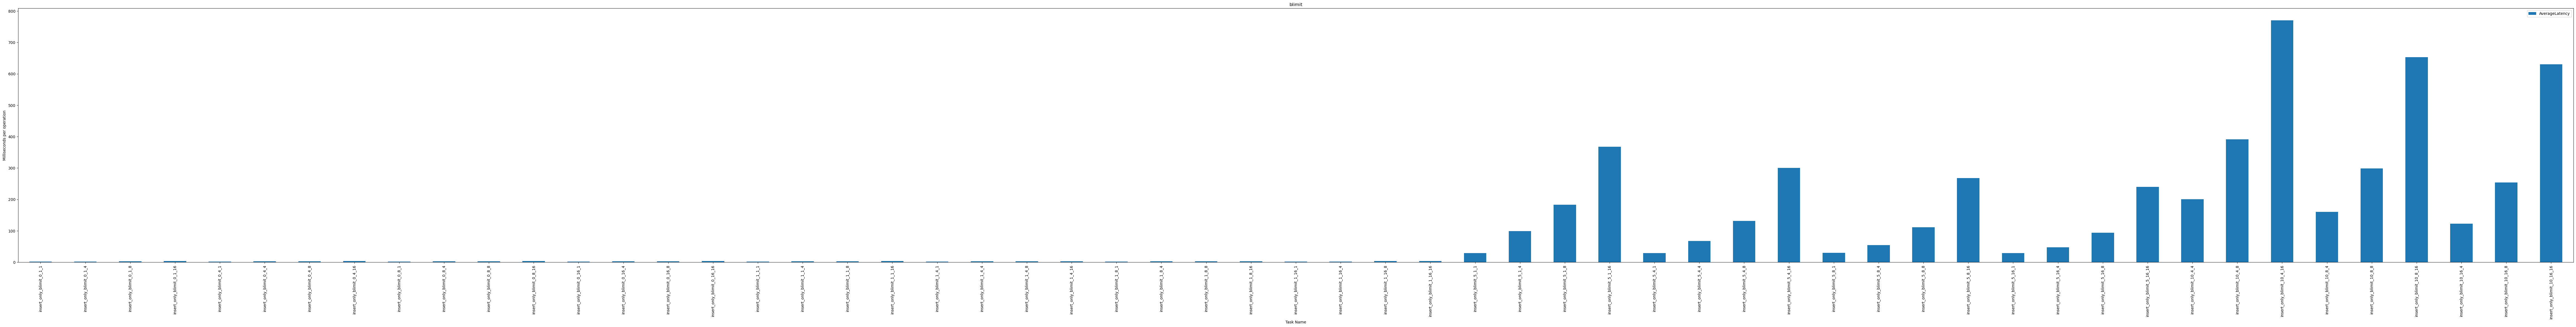

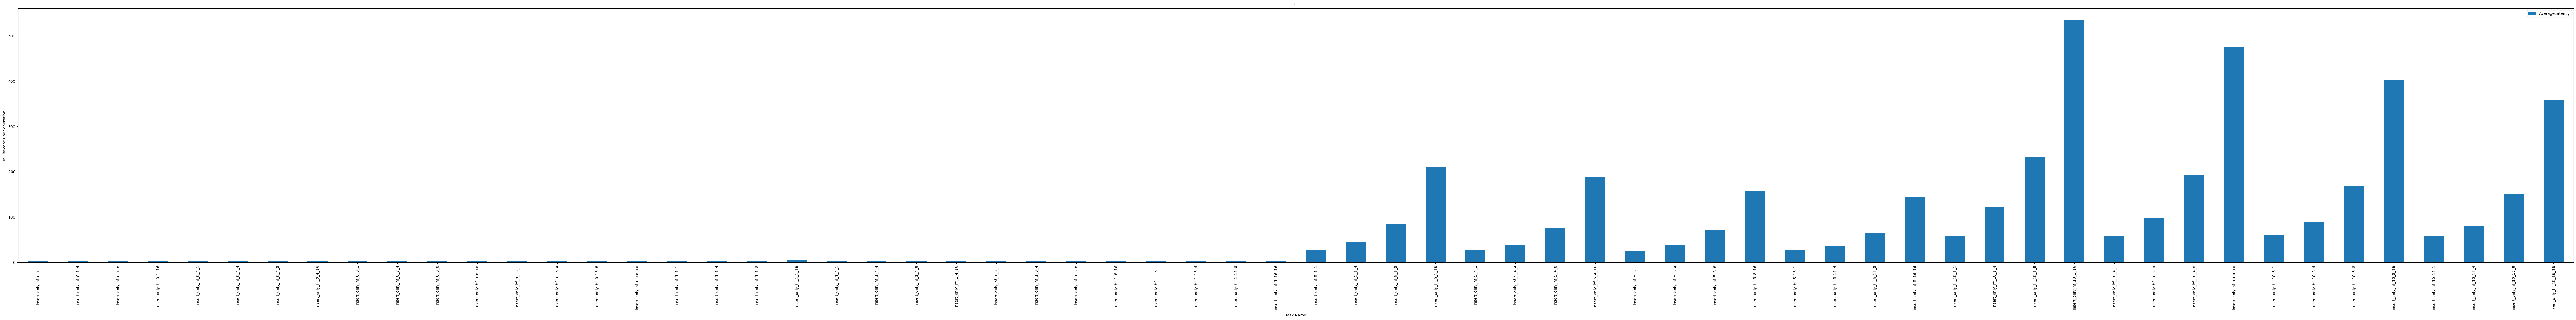

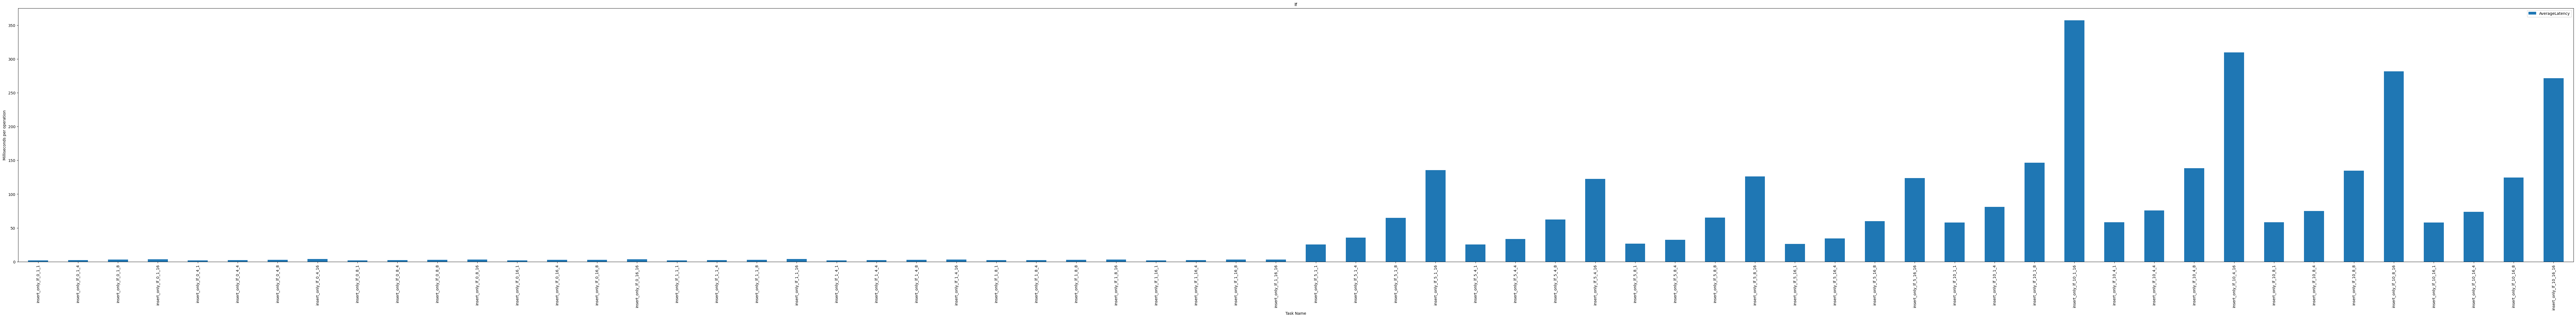

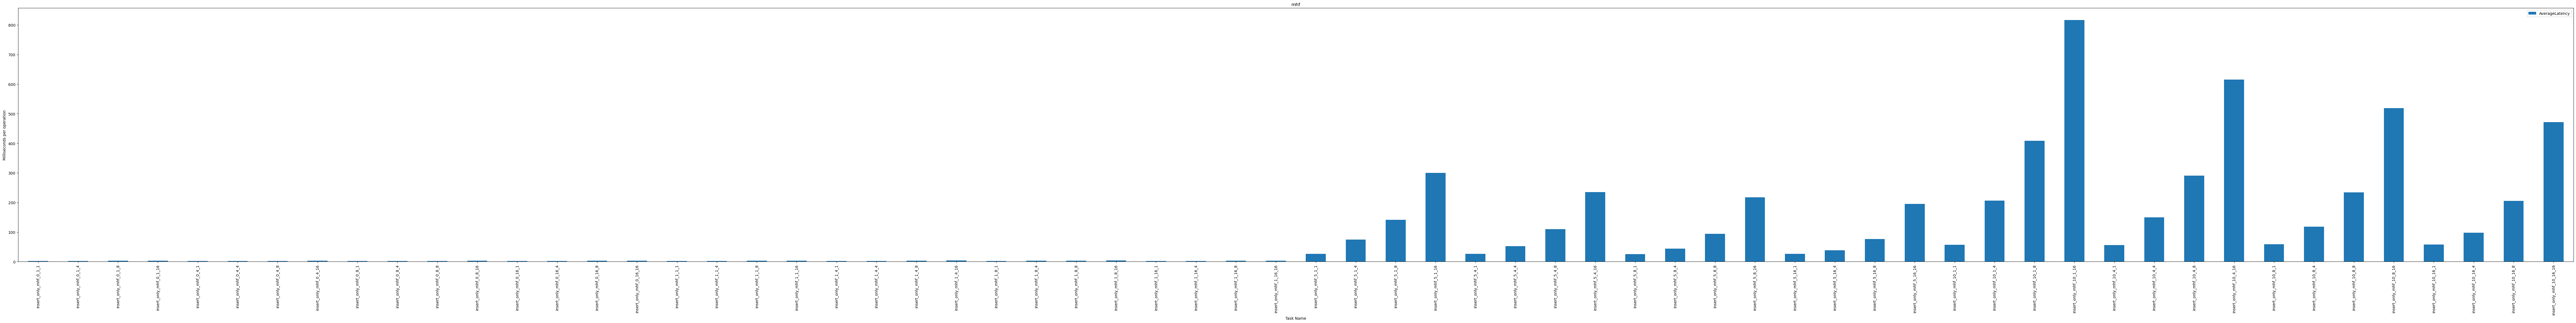

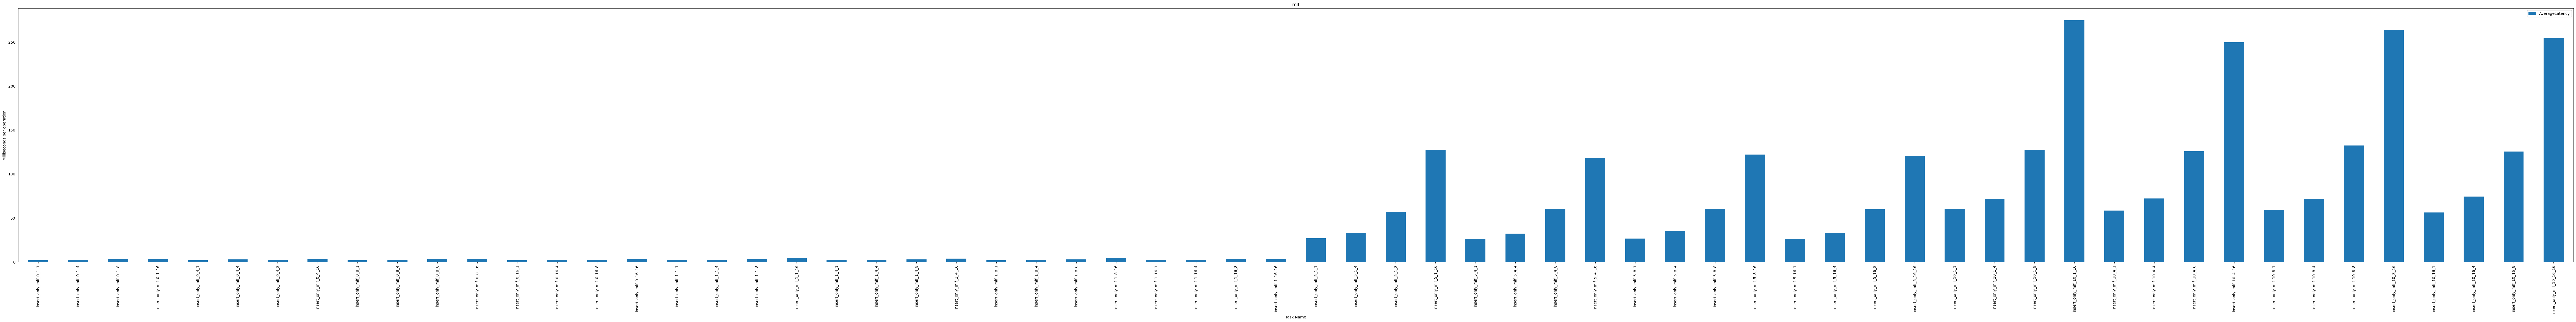

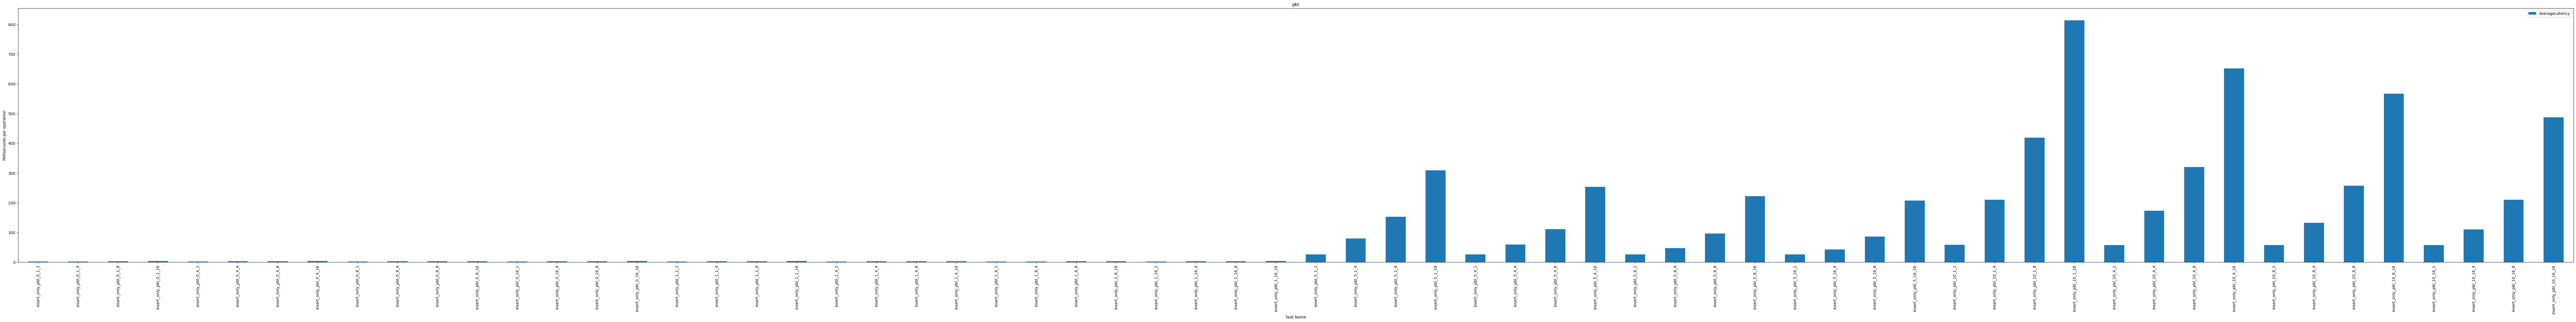

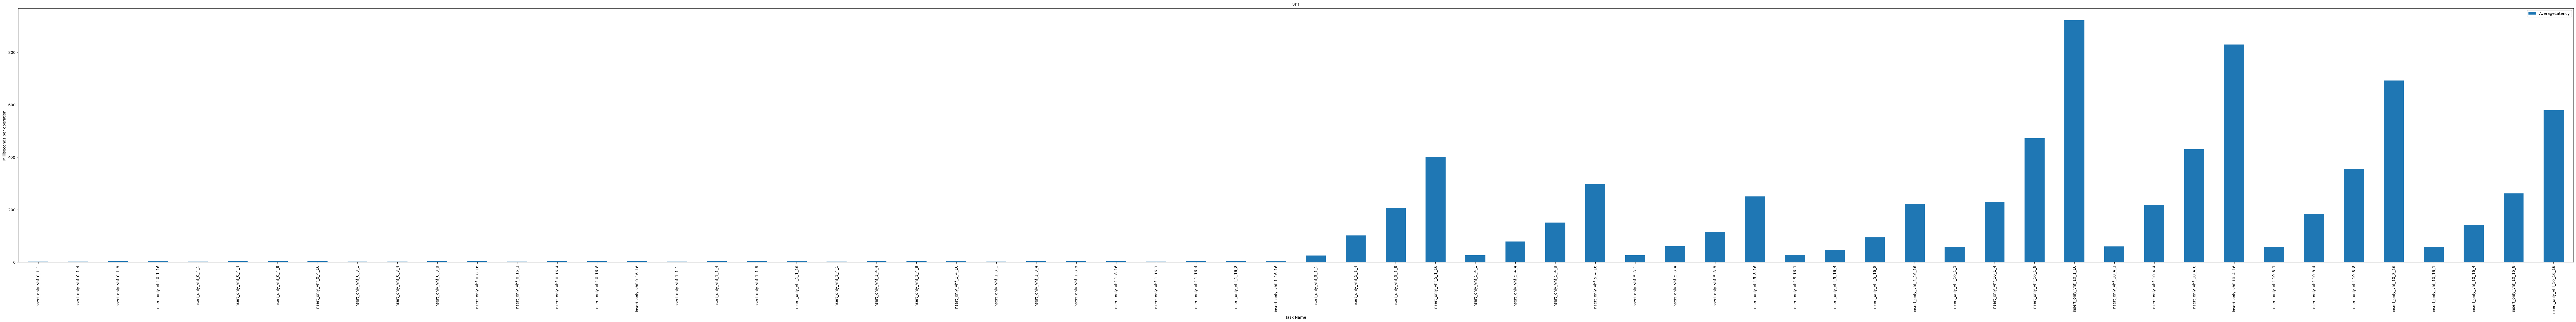

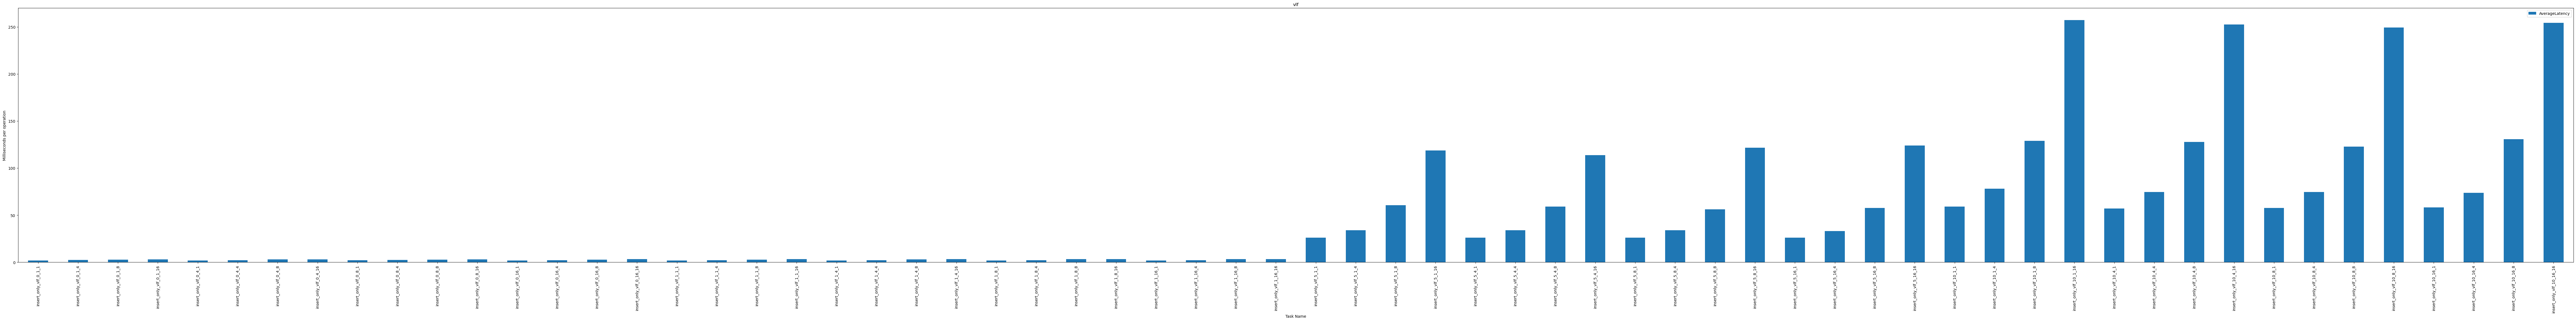

In [7]:
# Let's look at Latency
for name, group in pd.groupby(pd.Distribution):
    group.plot.bar(x="Task Name", y="AverageLatency", ylabel="Milliseconds per operation", figsize=(120,12)).set_title(name)

<AxesSubplot: title={'center': 'mhf_5_4_4'}, xlabel='total_ops', ylabel='pure_latency(ms)'>

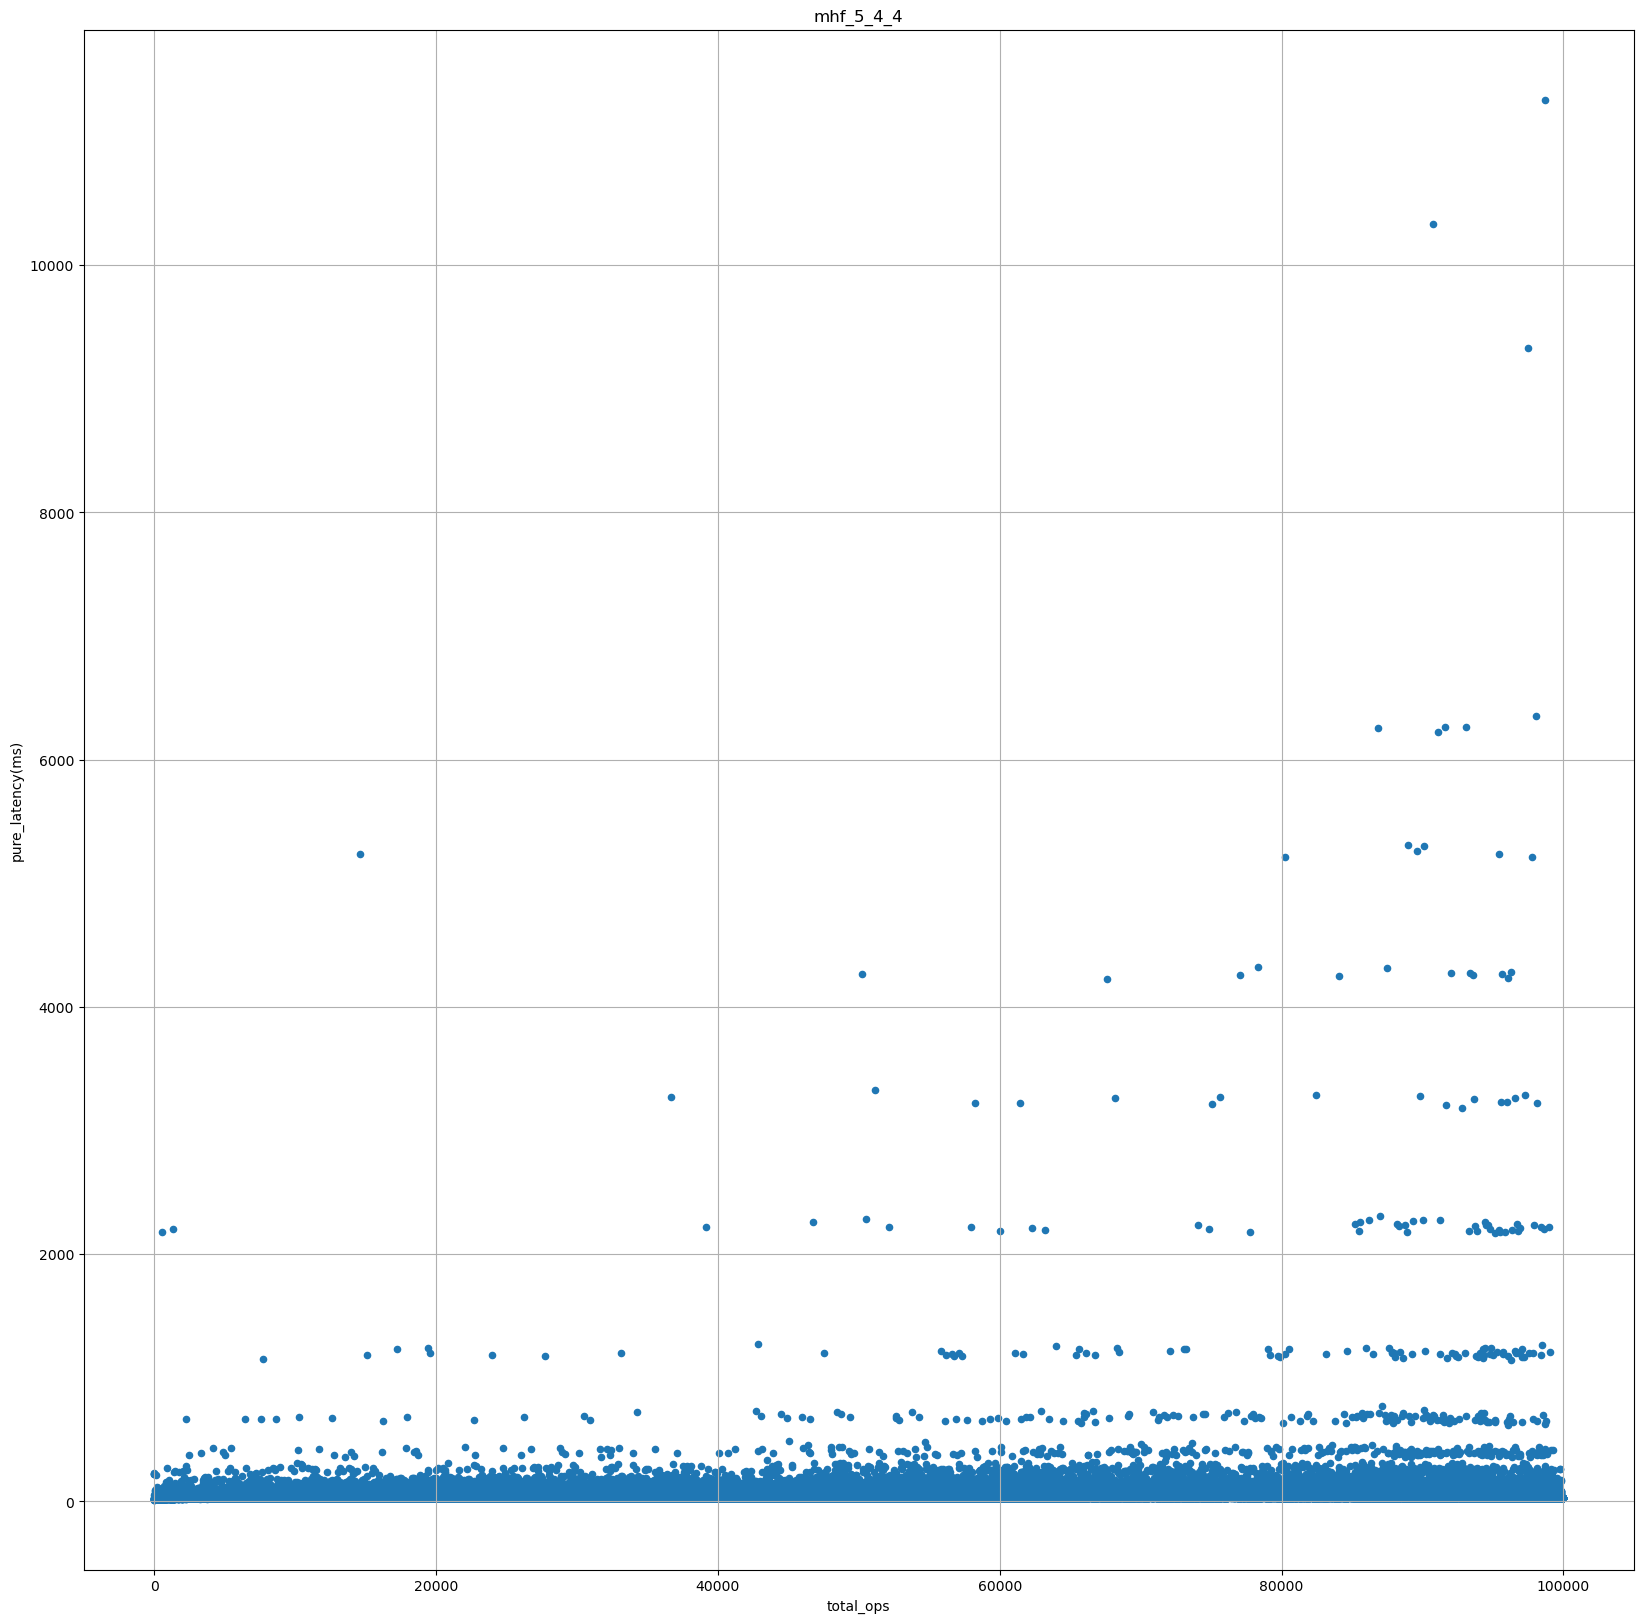

In [8]:
# Let's dig into per-op latency for something sane, like an mhf distribution
df_w = get_data("qe_test_insert/63e149bf3e8e862138abedc7/linux-1-node-replSet-fle.2022-11/insert_only_mhf_5_4_4/0/InsertActor.load.inserts.json").diff_data

df_w.plot(figsize=(20,20), x="total_ops", y= "pure_latency(ms)", kind="scatter", title=f"mhf_5_4_4", ylabel="pure_latency(ms)", grid=0.4)

5.859524191348855 log2(x) + -36.31547073653151


<AxesSubplot: xlabel='total_ops', ylabel='milliseconds'>

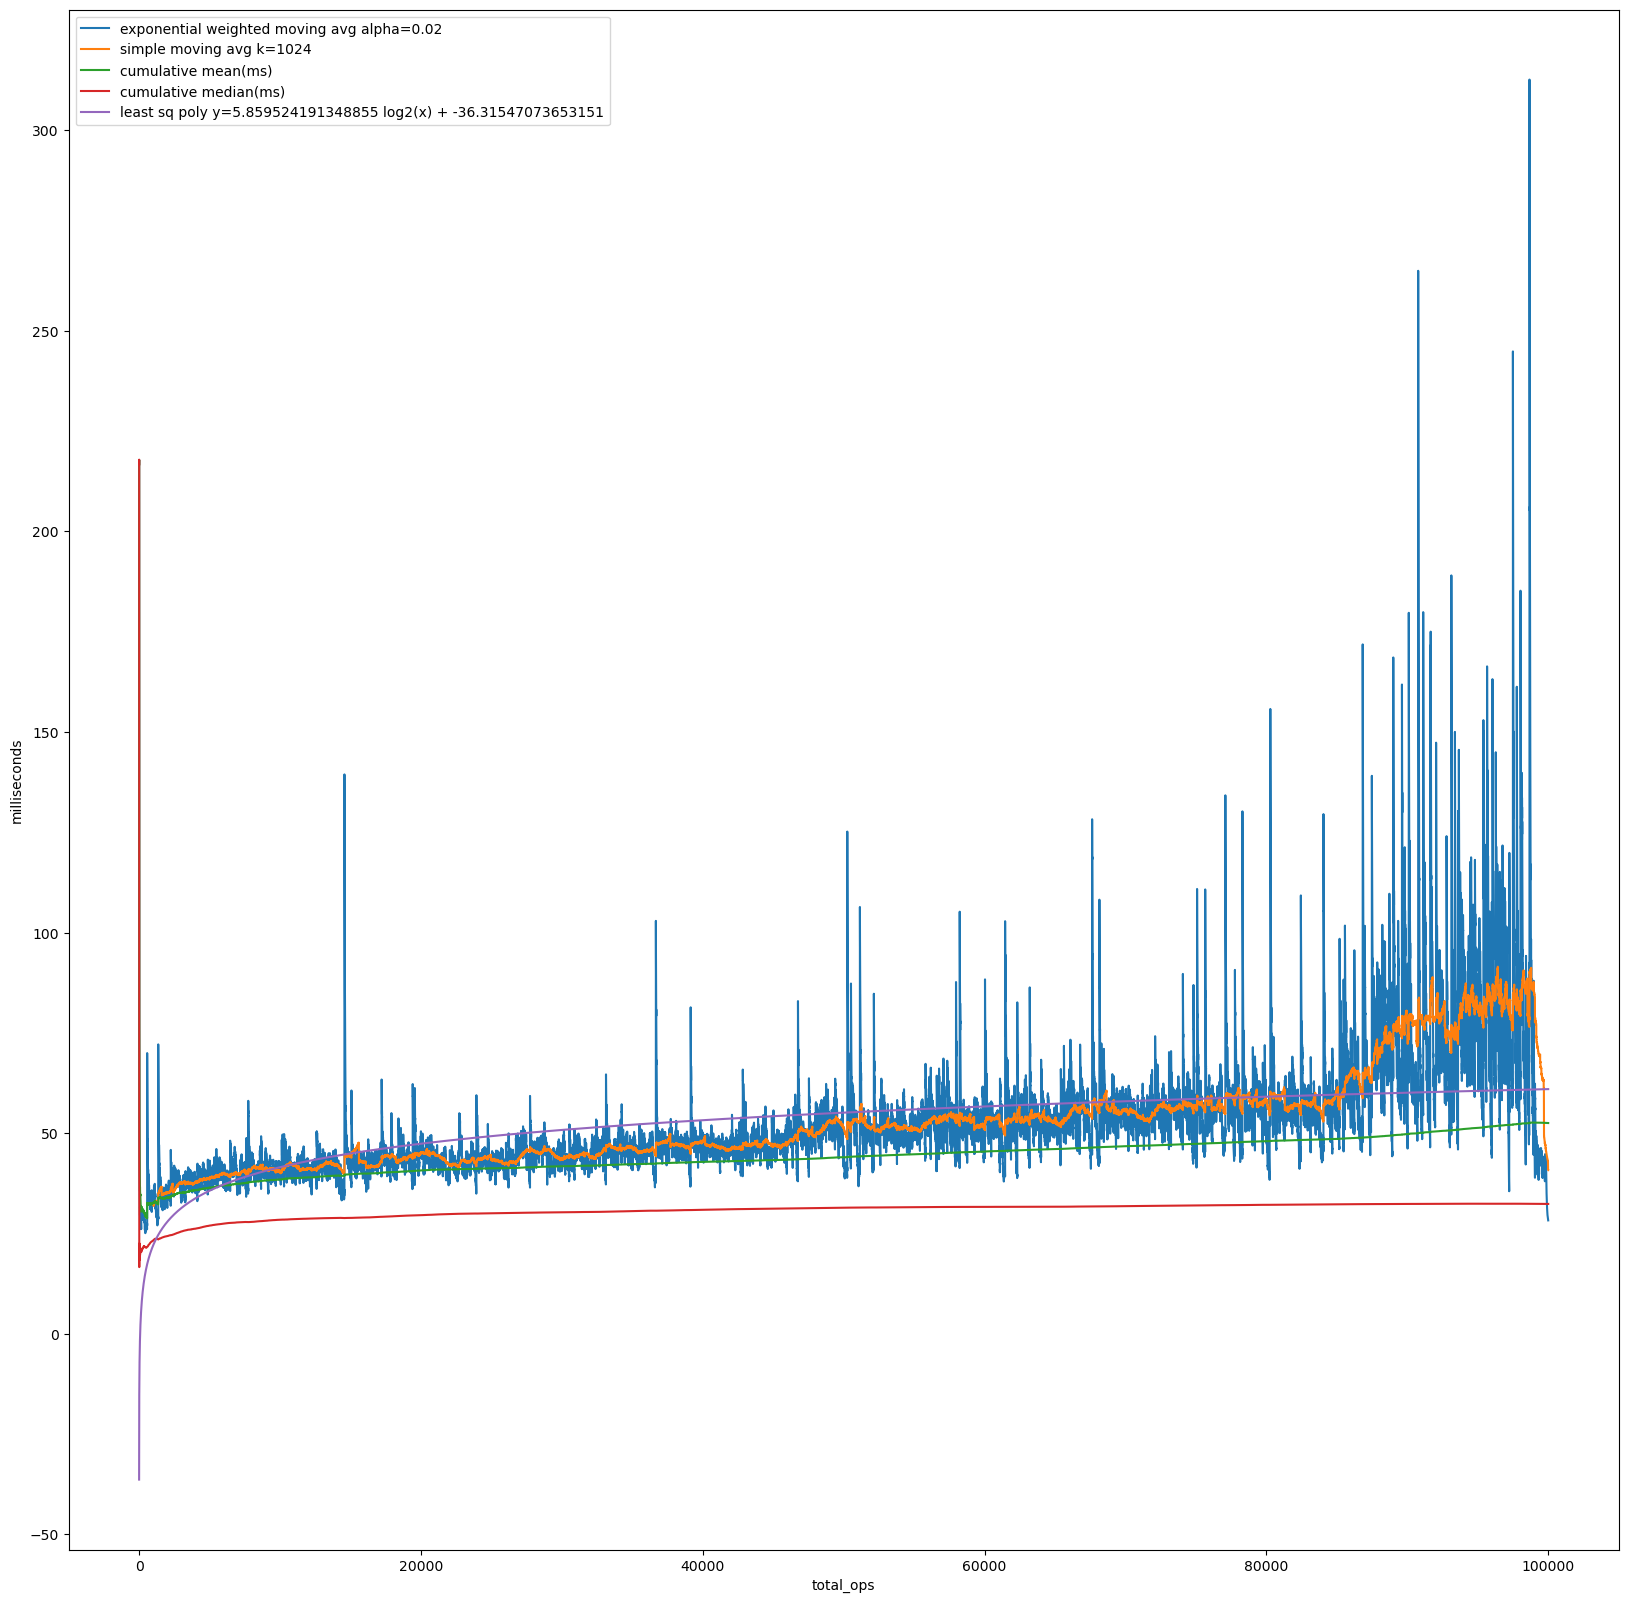

In [9]:
# Fit a distribution
plot_latency_stats(df_w, "total_ops", regr="log")

<AxesSubplot: title={'center': 'Insertion MHF 5 Encrypted Fields: Average Latency'}, xlabel='ContentionFactor', ylabel='Average Latency'>

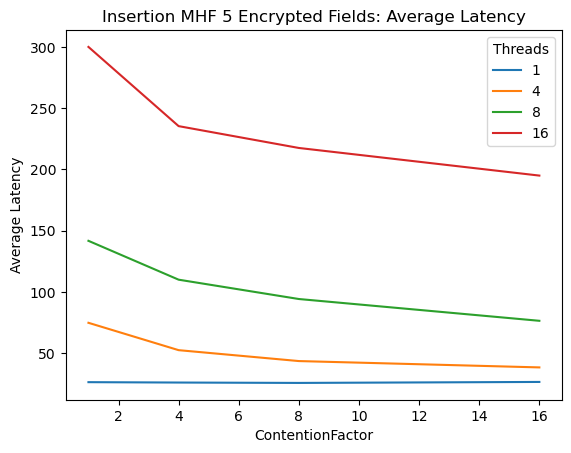

In [10]:
# Thread count vs Contention Factor for MHF
pd1 = pd.query("Distribution == 'mhf' & EncryptedFields == 5")
piv = pd1.pivot(index='ContentionFactor', columns="Threads", values="AverageLatency")

piv.plot(title="Insertion MHF 5 Encrypted Fields: Average Latency", ylabel="Average Latency")

<AxesSubplot: title={'center': 'Insertion MHF 5 Encrypted Fields: Average Latency'}, xlabel='ContentionFactor', ylabel='Average Latency'>

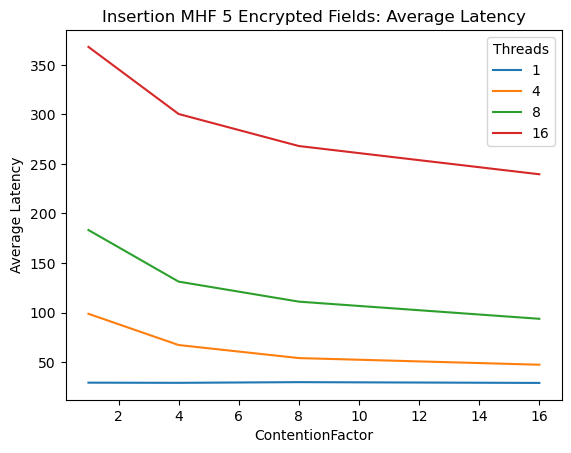

In [11]:
# Thread count vs Contention Factor for blimit
pd1 = pd.query("Distribution == 'blimit' & EncryptedFields == 5")
piv = pd1.pivot(index='ContentionFactor', columns="Threads", values="AverageLatency")

piv.plot(title="Insertion MHF 5 Encrypted Fields: Average Latency", ylabel="Average Latency")